<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>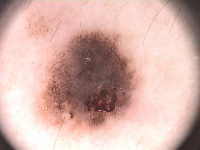</td><td>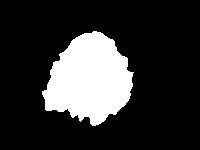</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [ ]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
import os
from skimage.io import imread
import numpy as np

kaggle_input_dir = '/kaggle/input/ph2dataset'
dataset_base_dir = os.path.join(kaggle_input_dir, 'PH2Dataset')

images = []
lesions = []

if not os.path.exists(dataset_base_dir):
    print(f"Ошибка: Директория '{dataset_base_dir}' не найдена.")
    print("Пожалуйста, проверьте точный путь к 'PH2 Dataset images' внутри '/kaggle/input/ph2dataset/'")
    # print("Содержимое /kaggle/input/ph2dataset/:", os.listdir(kaggle_input_dir)) # Раскомментируйте для отладки
else:
    print(f"Начинаем сканирование директории: {dataset_base_dir}")

    for current_root, dirs, files in os.walk(dataset_base_dir):
        if files:
            if current_root.endswith('_Dermoscopic_Image'):
                image_path = os.path.join(current_root, files[0])
                # print(f"  Найдено изображение: {image_path}") # Раскомментируйте для отладки
                try:
                    images.append(imread(image_path))
                except Exception as e:
                    print(f"    Не удалось прочитать изображение {image_path}: {e}")

            if current_root.endswith('_lesion'):
                lesion_path = os.path.join(current_root, files[0])
                # print(f"  Найдена маска: {lesion_path}") # Раскомментируйте для отладки
                try:
                    lesions.append(imread(lesion_path, as_gray=False))
                except Exception as e:
                    print(f"    Не удалось прочитать маску {lesion_path}: {e}")

print(f"\nЗагружено изображений: {len(images)}")
print(f"Загружено масок: {len(lesions)}")

if images and lesions:
    print(f"Размер первого изображения: {images[0].shape}")
    print(f"Размер первой маски: {lesions[0].shape}")
    if len(images) != len(lesions):
        print("ВНИМАНИЕ: Количество изображений и масок не совпадает!")

Начинаем сканирование директории: /kaggle/input/ph2dataset/PH2Dataset

Загружено изображений: 200
Загружено масок: 200
Размер первого изображения: (576, 767, 3)
Размер первой маски: (576, 767)


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

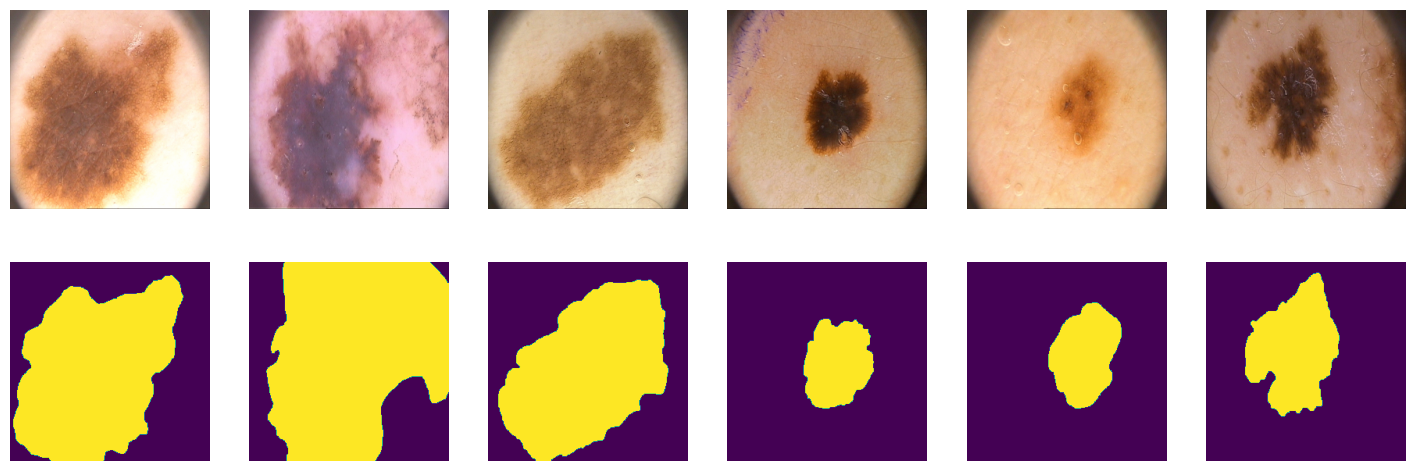

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
# !pip install torchmetrics

In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** \\
$$\mathcal
y * -log(sigmoid(\hat y\ )) + (1 - y) * -log(1 - sigmoid(\hat y\ )) \\
= y * -log(1 / (1 + exp(-\hat y\ ))) + (1 - y) * -log(exp(-\hat y\ ) / (1 + exp(-\hat y\ ))) \\
= y * log(1 + exp(-\hat y\ )) + (1 - y) * (-log(exp(-\hat y\ )) + log(1 + exp(-\hat y\ ))) \\
= y * log(1 + exp(-\hat y\ )) + (1 - y) * (\hat y\  + log(1 + exp(-\hat y\ ))) \\
= (1 - y) * \hat y\  + log(1 + exp(-\hat y\ )) \\
= \hat y\ - \hat y\  * y + log(1 + exp(-\hat y\ )) $$


### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real, eps=1e-8):
  return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred) + eps)).sum()
def bce_true(y_pred, y_real):
  return - (y_real * torch.log(y_pred.sigmoid()) + (1 - y_real) * torch.log(1 - y_pred.sigmoid())).sum()


Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.8311920166015625
BCE loss честно посчитанный = 5.831192493438721
BCE loss from torch bce_torch = 5.831192493438721
BCE loss from torch with logits bce_torch = 5.831192970275879


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 14.775851249694824
BCE loss честно посчитанный = 14.775850296020508
BCE loss from torch bce_torch = 14.775850296020508
BCE loss from torch with logits bce_torch = 14.775851249694824


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 7.96MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 6.40MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/kaggle/working/for_asserts/'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

/tmp/ipykernel_31/388513312.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
/tmp/ipykernel_3

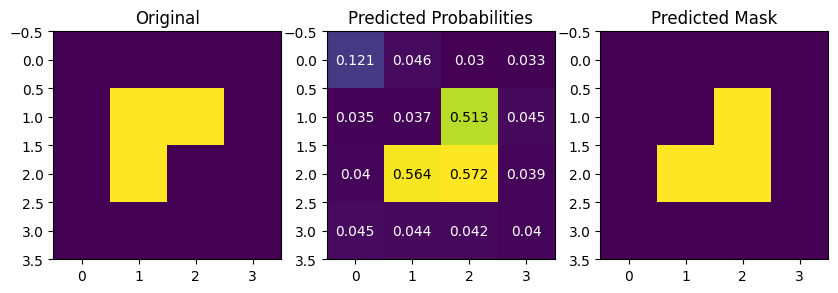

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

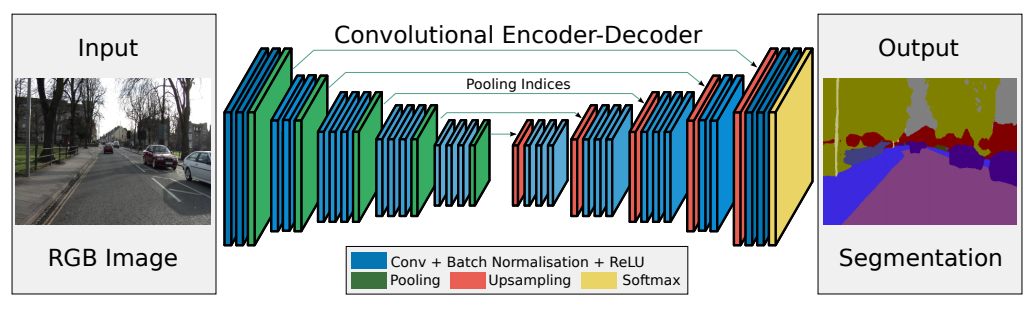

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [ ]:
import torch
import torch.nn as nn

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices = True)

        # Decoder
        self.unpool5 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        )


    def forward(self, x):
        # Encoder
        size1_pre = x.size()
        x = self.conv1(x)
        x, idxs1 = self.pool1(x)

        size2_pre = x.size()
        x = self.conv2(x)
        x, idxs2 = self.pool2(x)

        size3_pre = x.size()
        x = self.conv3(x)
        x, idxs3 = self.pool3(x)

        size4_pre = x.size()
        x = self.conv4(x)
        x, idxs4 = self.pool4(x)

        size5_pre = x.size()
        x = self.conv5(x)
        x, idxs5 = self.pool5(x)

        # Decoder
        x = self.unpool5(x, idxs5, output_size=size5_pre)
        x = self.dec_conv5(x)

        x = self.unpool4(x, idxs4, output_size=size4_pre)
        x = self.dec_conv4(x)

        x = self.unpool3(x, idxs3, output_size=size3_pre)
        x = self.dec_conv3(x)

        x = self.unpool2(x, idxs2, output_size=size2_pre)
        x = self.dec_conv2(x)

        x = self.unpool1(x, idxs1, output_size=size1_pre)
        x = self.dec_conv1(x)

        output = x
        return output

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
ckpt_path = '/kaggle/working'

In [ ]:
iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [ ]:
def train(train_dataloader, val_dataloader, model, optimizer, criterion, num_epoch):
    train_loss = []
    val_loss = []
    val_iou = []
    best_val_loss = float('inf')
    model.to(device)

    for epoch in tqdm(range(num_epoch), desc="Epoch Progress"):
        avg_train_loss = 0
        model.train()
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch)
            cur_train_loss = criterion(logits, y_batch)
            cur_train_loss.backward()
            optimizer.step()

            avg_train_loss += cur_train_loss.item()

        avg_val_loss = 0
        avg_val_iou = 0
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                logits = model(x_batch)
                cur_val_loss = criterion(logits, y_batch)

                cur_val_iou = iou_score(logits, y_batch)

                avg_val_loss += cur_val_loss.item()
                avg_val_iou += cur_val_iou.item()

        avg_train_loss_epoch = avg_train_loss / len(train_dataloader)
        avg_val_loss_epoch = avg_val_loss / len(val_dataloader)
        avg_val_iou_epoch = avg_val_iou / len(val_dataloader)

        train_loss.append(avg_train_loss_epoch)
        val_loss.append(avg_val_loss_epoch)
        val_iou.append(avg_val_iou_epoch)

        # if avg_val_loss_epoch < best_val_loss:
        #      best_val_loss = avg_val_loss_epoch
        #      torch.save(model.state_dict(), f'{ckpt_path}/_best_val_loss.pt')

        print(f'Epoch {epoch + 1}: train loss = {avg_train_loss_epoch}   val loss = {avg_val_loss_epoch}   val iou = {avg_val_iou_epoch}')

    statistics = {'train loss': train_loss,
                  'val_loss': val_loss,
                  'val_iou': val_iou}

    return statistics

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
print("BCE")
segnet_model_bce = SegNet().to(device)
opt_bce = torch.optim.AdamW(segnet_model_bce.parameters(), lr=3e-4)
bce = nn.BCEWithLogitsLoss()
statistics_bce_segnet = train(train_dataloader, valid_dataloader, segnet_model_bce, opt_bce, bce, 30)

BCE


Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train loss = 0.8444174230098724   val loss = 0.6999841034412384   val iou = 0.2594010680913925
Epoch 2: train loss = 0.708450973033905   val loss = 0.688809871673584   val iou = 0.1828596070408821
Epoch 3: train loss = 0.6482079178094864   val loss = 0.6700256168842316   val iou = 0.03773944452404976
Epoch 4: train loss = 0.6177351474761963   val loss = 0.6486345529556274   val iou = 0.00949192326515913
Epoch 5: train loss = 0.5742776244878769   val loss = 0.6791515052318573   val iou = 0.021055581979453564
Epoch 6: train loss = 0.48680590093135834   val loss = 1.1974284052848816   val iou = 0.29024000465869904
Epoch 7: train loss = 0.3902333751320839   val loss = 1.75894296169281   val iou = 0.3768945038318634
Epoch 8: train loss = 0.34044862538576126   val loss = 1.2434649467468262   val iou = 0.39730487763881683
Epoch 9: train loss = 0.30335143953561783   val loss = 0.5592139214277267   val iou = 0.4652991443872452
Epoch 10: train loss = 0.2909759283065796   val loss = 0.79

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(test_dataloader, model, ckpt_path):
    # model.load_state_dict(torch.load(f'{ckpt_path}/{ckpt_name}')).to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0

    with torch.no_grad():
        for x_batch, y_batch in test_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = model(x_batch)
            avg_iou += iou_score(logits, y_batch)

    return avg_iou/len(test_dataloader)

In [ ]:
test(test_dataloader, segnet_model_bce, ckpt_path)

tensor(0.7397, device='cuda:0')

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    prob = logits.sigmoid()
    preds = (prob > threshold).float()
    tp = torch.sum(preds*labels)
    fp = torch.sum(preds) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8
    score = (2 * tp + eps) / (2 * tp + fn + fp + eps)
    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1).to(device)
dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].int())
dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.6667, device='cuda:0')

In [ ]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

"\nесли вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():\n\nfrom torchmetrics.classification import Dice\n\ndice = Dice(average='micro').to(device)\n\n"

In [ ]:
assert dice((dummpy_sample['logits'].sigmoid() > 0.5).int(), dummpy_sample['labels'].int()) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''

    '''
    prob = logits.sigmoid()
    tp = torch.sum(prob*labels)
    fp = torch.sum(prob) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8
    score = (2 * tp + eps) / (2 * tp + fn + fp + eps)
    loss = 1 - score

    return loss

Проверка на корректность:

In [ ]:
#проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    loss = - torch.mean((1 - (y_pred.sigmoid() * y_real + (1 - y_pred.sigmoid()) * (1 - y_real))) ** gamma  * (y_real * torch.log(y_pred.sigmoid() + eps) + (1 - y_real) * torch.log(1 - y_pred.sigmoid() + eps)))

    return loss

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='mean')
focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2)

tensor(0.2260, device='cuda:0')

In [ ]:
assert np.isclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='mean').to('cpu'),  focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0).to('cpu'))

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [ ]:
def tversky_loss(logits, labels, alpha=0.5, betta=0.5, eps=1e-8):

    prob = logits.sigmoid()
    tp = torch.sum(prob*labels)
    fp = torch.sum(prob) - tp
    fn = torch.sum(labels) - tp
    tversky_index = (tp + eps) / (tp + alpha*fp + betta*fn + eps)
    loss = 1 - tversky_index
    return loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
print("DICE")
segnet_model_dice = SegNet().to(device)
opt_dice = torch.optim.AdamW(segnet_model_dice.parameters(), lr=3e-4)
dice = dice_loss
statistics_dice_segnet = train(train_dataloader, valid_dataloader, segnet_model_dice, opt_dice, dice, 30)

DICE


Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train loss = 0.54512058198452   val loss = 0.6411628127098083   val iou = 0.2593885436654091
Epoch 2: train loss = 0.361155167222023   val loss = 0.6746993958950043   val iou = 0.014935248531401157
Epoch 3: train loss = 0.2360205501317978   val loss = 0.7789976298809052   val iou = 4.512864734351751e-06
Epoch 4: train loss = 0.17081458866596222   val loss = 0.90852490067482   val iou = 0.0
Epoch 5: train loss = 0.1626465916633606   val loss = 0.9655648469924927   val iou = 0.0
Epoch 6: train loss = 0.16665813326835632   val loss = 0.9341755509376526   val iou = 0.027626516297459602
Epoch 7: train loss = 0.14426545798778534   val loss = 0.6852225661277771   val iou = 0.1887434870004654
Epoch 8: train loss = 0.1310093104839325   val loss = 0.32960134744644165   val iou = 0.5112312138080597
Epoch 9: train loss = 0.12379606068134308   val loss = 0.19161441922187805   val iou = 0.6811506152153015
Epoch 10: train loss = 0.1411413699388504   val loss = 0.18259567022323608   val iou =

In [ ]:
test(test_dataloader, segnet_model_dice, ckpt_path)

tensor(0.7984, device='cuda:0')

In [ ]:
print("FOCAL")
segnet_model_focal = SegNet().to(device)
opt_focal = torch.optim.AdamW(segnet_model_focal.parameters(), lr=3e-4)
focal = focal_loss
statistics_focal_segnet = train(train_dataloader, valid_dataloader, segnet_model_focal, opt_focal, focal, 30)

FOCAL


Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train loss = 0.514006894081831   val loss = 0.19585947692394257   val iou = 0.0
Epoch 2: train loss = 0.19580985605716705   val loss = 0.19051768630743027   val iou = 0.2763931602239609
Epoch 3: train loss = 0.15953322499990463   val loss = 0.17197495698928833   val iou = 0.20712267607450485
Epoch 4: train loss = 0.16025744006037712   val loss = 0.15924087911844254   val iou = 0.007119216490536928
Epoch 5: train loss = 0.1527707800269127   val loss = 0.15419664233922958   val iou = 0.0013314938405528665
Epoch 6: train loss = 0.1491478867828846   val loss = 0.15188978612422943   val iou = 0.0015055122785270214
Epoch 7: train loss = 0.1442468799650669   val loss = 0.1482304111123085   val iou = 0.009515825542621315
Epoch 8: train loss = 0.13809289038181305   val loss = 0.14037422090768814   val iou = 0.03240113891661167
Epoch 9: train loss = 0.13260116055607796   val loss = 0.1304720751941204   val iou = 0.05741197243332863
Epoch 10: train loss = 0.1275887917727232   val loss = 

In [ ]:
test(test_dataloader, segnet_model_focal, ckpt_path)

tensor(0.7800, device='cuda:0')

In [ ]:
print("TVERSKY")
segnet_model_tversky = SegNet().to(device)
opt_tversky = torch.optim.AdamW(segnet_model_tversky.parameters(), lr=3e-4)
tversky = tversky_loss
statistics_tversky_segnet = train(train_dataloader, valid_dataloader, segnet_model_tversky, opt_tversky, tversky, 30)

TVERSKY


Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train loss = 0.5921287685632706   val loss = 0.6419008374214172   val iou = 0.2729424387216568
Epoch 2: train loss = 0.49616381525993347   val loss = 0.632503867149353   val iou = 0.27645522356033325
Epoch 3: train loss = 0.45037582516670227   val loss = 0.6115323901176453   val iou = 0.2766718342900276
Epoch 4: train loss = 0.37640567123889923   val loss = 0.5313140153884888   val iou = 0.35431744158267975
Epoch 5: train loss = 0.23714376986026764   val loss = 0.5084432661533356   val iou = 0.31364038586616516
Epoch 6: train loss = 0.18536676466464996   val loss = 0.5101113319396973   val iou = 0.3338112533092499
Epoch 7: train loss = 0.15266737341880798   val loss = 0.33282580971717834   val iou = 0.5197793394327164
Epoch 8: train loss = 0.1443759649991989   val loss = 0.2866080105304718   val iou = 0.5665233731269836
Epoch 9: train loss = 0.14362302422523499   val loss = 0.21625417470932007   val iou = 0.6465245485305786
Epoch 10: train loss = 0.14693644642829895   val loss

In [ ]:
test(test_dataloader, segnet_model_tversky, ckpt_path)

tensor(0.8107, device='cuda:0')

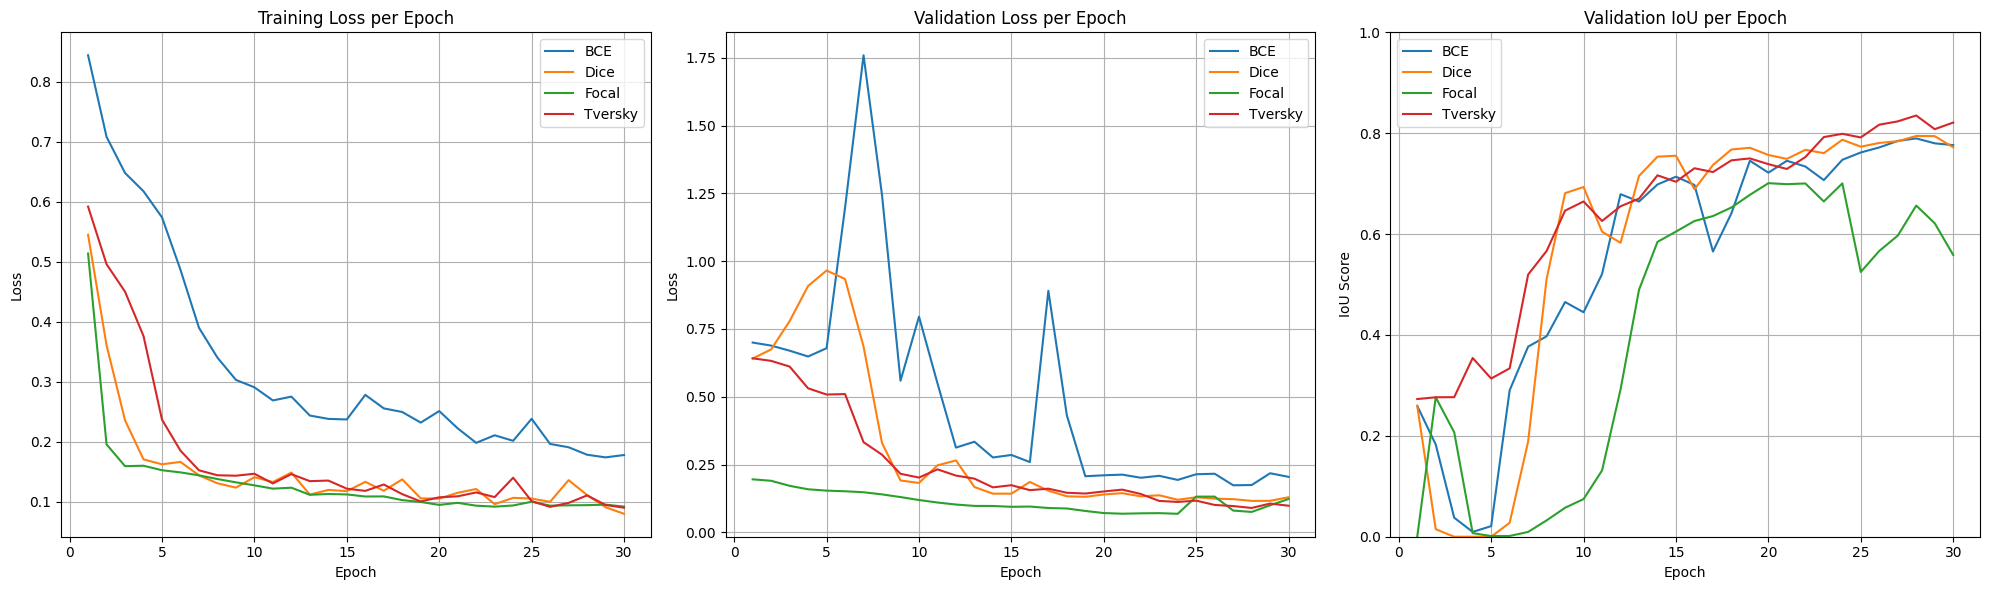

In [ ]:
stats_list_segnet = {
    "BCE": statistics_bce_segnet,
    "Dice": statistics_dice_segnet,
    "Focal": statistics_focal_segnet,
    "Tversky": statistics_tversky_segnet,
}

train_loss_key = 'train loss'
val_loss_key = 'val_loss'
val_iou_key = 'val_iou'


num_epochs = 30
epochs = range(1, num_epochs + 1)


# --- Создание графиков ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- График 1: Training Loss ---
ax = axes[0]
for name, stats in stats_list_segnet.items():
    ax.plot(epochs, stats[train_loss_key], label=f'{name}')

ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

# --- График 2: Validation Loss ---
ax = axes[1]
for name, stats in stats_list_segnet.items():
    ax.plot(epochs, stats[val_loss_key], label=f'{name}')

ax.set_title('Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

# --- График 3: Validation IoU ---
ax = axes[2]
for name, stats in stats_list_segnet.items():
    ax.plot(epochs, stats[val_iou_key], label=f'{name}')

ax.set_title('Validation IoU per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('IoU Score')

ax.set_ylim(0, 1)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

**РЕВЬЮ ПО ЛОССАМ**

Быстрее всего модель сходится при использовании Focal loss (он изначально почему то очень мал) и Tversky loss. Немного медленнее сходится DICE loss, самым медленным оказался BCE loss.

Наилучшая метрика была достигнута при использовании Tversky loss, затем идет DICE, BCE и самым худшим получился Focal(данный лосс в принципе странно себя повел при обучении)

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

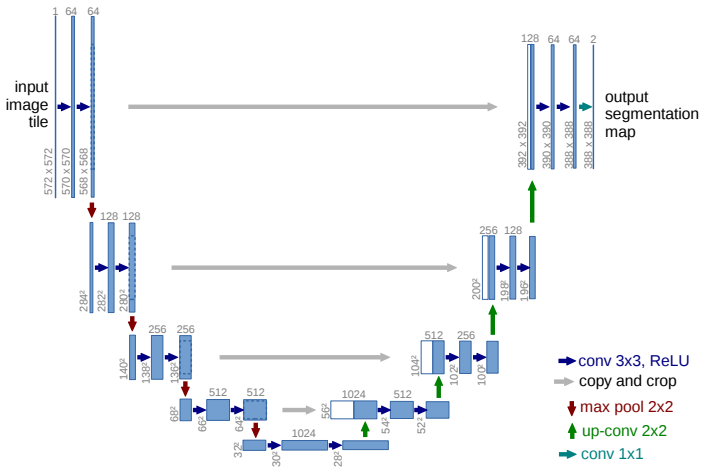

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

        self.up_trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.up_trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.up_trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.up_trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final = nn.Conv2d(64, n_class, kernel_size=1)

    def _concat_skip(self, upsampled, skip_connection):
        # Иногда из-за пулинга/транспонированной свертки размеры могут отличаться на 1 пиксель
        diffY = skip_connection.size()[2] - upsampled.size()[2]
        diffX = skip_connection.size()[3] - upsampled.size()[3]

        # Дополняем (pad) тензор после апсемплинга, чтобы размеры совпали
        # Паддинг: (слева, справа, сверху, снизу)
        upsampled = F.pad(upsampled, [diffX // 2, diffX - diffX // 2,
                                      diffY // 2, diffY - diffY // 2])

        # Конкатенируем по оси каналов (dim=1)
        return torch.cat([skip_connection, upsampled], dim=1)

    def forward(self, x):

        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        bottleneck = self.conv5(p4)

        up1 = self.up_trans1(bottleneck)
        concat1 = self._concat_skip(up1, c4)
        dec1 = self.up_conv1(concat1)

        up2 = self.up_trans2(dec1)
        concat2 = self._concat_skip(up2, c3)
        dec2 = self.up_conv2(concat2)

        up3 = self.up_trans3(dec2)
        concat3 = self._concat_skip(up3, c2)
        dec3 = self.up_conv3(concat3)

        up4 = self.up_trans4(dec3)
        concat4 = self._concat_skip(up4, c1)
        dec4 = self.up_conv4(concat4)

        output = self.final(dec4)

        return output

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [ ]:
unet_model_bce = UNet().to(device)
opt_unet_bce = torch.optim.AdamW(unet_model_bce.parameters(), lr=3e-4)
bce = bce_loss
statistics_bce_unet = train(train_dataloader, valid_dataloader, unet_model_bce, opt_unet_bce, bce, 30)

Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train loss = 0.5893845707178116   val loss = 0.659667044878006   val iou = 0.0
Epoch 2: train loss = 0.40857087075710297   val loss = 0.6301440298557281   val iou = 0.0
Epoch 3: train loss = 0.3620487004518509   val loss = 0.5896833837032318   val iou = 0.0
Epoch 4: train loss = 0.3308744430541992   val loss = 0.6768880486488342   val iou = 0.19056719541549683
Epoch 5: train loss = 0.3259802311658859   val loss = 0.5504167377948761   val iou = 0.0008464493439532816
Epoch 6: train loss = 0.2946629449725151   val loss = 0.4819018989801407   val iou = 0.03667843248695135
Epoch 7: train loss = 0.28725459426641464   val loss = 0.511627808213234   val iou = 0.21507258713245392
Epoch 8: train loss = 0.27403581514954567   val loss = 0.37587180733680725   val iou = 0.5379056483507156
Epoch 9: train loss = 0.28366731852293015   val loss = 0.2881595194339752   val iou = 0.7231166958808899
Epoch 10: train loss = 0.26739174500107765   val loss = 0.32936179637908936   val iou = 0.7014369070

In [ ]:
unet_model_dice = UNet().to(device)
opt_unet_dice = torch.optim.AdamW(unet_model_dice.parameters(), lr=3e-4)
dice = dice_loss
statistics_dice_unet = train(train_dataloader, valid_dataloader, unet_model_dice, opt_unet_dice, dice, 30)

Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train loss = 0.4930388778448105   val loss = 0.6474840641021729   val iou = 0.0
Epoch 2: train loss = 0.3603731691837311   val loss = 0.6515405774116516   val iou = 0.00046443199971690774
Epoch 3: train loss = 0.3157512694597244   val loss = 0.6751370131969452   val iou = 0.0
Epoch 4: train loss = 0.30052976310253143   val loss = 0.6560114026069641   val iou = 0.013886830769479275
Epoch 5: train loss = 0.2799642086029053   val loss = 0.7746967077255249   val iou = 0.0005051905172877014
Epoch 6: train loss = 0.26076550781726837   val loss = 0.4163860082626343   val iou = 0.5511089116334915
Epoch 7: train loss = 0.2560848742723465   val loss = 0.3425149917602539   val iou = 0.6563556492328644
Epoch 8: train loss = 0.2425878643989563   val loss = 0.31581100821495056   val iou = 0.6748449504375458
Epoch 9: train loss = 0.22991599142551422   val loss = 0.295274943113327   val iou = 0.6692302525043488
Epoch 10: train loss = 0.23328688740730286   val loss = 0.28143566846847534   val 

In [ ]:
unet_model_focal = UNet().to(device)
opt_unet_focal = torch.optim.AdamW(unet_model_focal.parameters(), lr=3e-4)
focal = focal_loss
statistics_focal_unet = train(train_dataloader, valid_dataloader, unet_model_focal, opt_unet_focal, focal, 30)

Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train loss = 0.15191474929451942   val loss = 0.16424790769815445   val iou = 0.0
Epoch 2: train loss = 0.08681023865938187   val loss = 0.15799038112163544   val iou = 0.0
Epoch 3: train loss = 0.07821311615407467   val loss = 0.14223241806030273   val iou = 0.0
Epoch 4: train loss = 0.06550089456140995   val loss = 0.13342931121587753   val iou = 0.0002703143109101802
Epoch 5: train loss = 0.05958882160484791   val loss = 0.11721324548125267   val iou = 0.06500526145100594
Epoch 6: train loss = 0.057800011709332466   val loss = 0.14478310197591782   val iou = 0.08388011530041695
Epoch 7: train loss = 0.056515113450586796   val loss = 0.16839555650949478   val iou = 0.3795791119337082
Epoch 8: train loss = 0.05588392447680235   val loss = 0.17065347731113434   val iou = 0.4063146859407425
Epoch 9: train loss = 0.05446217302232981   val loss = 0.17741023004055023   val iou = 0.48306065797805786
Epoch 10: train loss = 0.05846020672470331   val loss = 0.09759368374943733   val i

In [ ]:
unet_model_tversky = UNet().to(device)
opt_unet_tversky = torch.optim.AdamW(unet_model_tversky.parameters(), lr=3e-4)
tverky = tversky_loss
statistics_tversky_unet = train(train_dataloader, valid_dataloader, unet_model_tversky, opt_unet_tversky, tversky, 30)

Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train loss = 0.470138356089592   val loss = 0.6495763957500458   val iou = 0.0
Epoch 2: train loss = 0.33846496045589447   val loss = 0.6565051674842834   val iou = 0.0
Epoch 3: train loss = 0.2924046069383621   val loss = 0.6935059428215027   val iou = 0.0
Epoch 4: train loss = 0.2779632806777954   val loss = 0.8110824823379517   val iou = 0.0
Epoch 5: train loss = 0.2631222754716873   val loss = 0.7148045003414154   val iou = 0.026181045919656754
Epoch 6: train loss = 0.2533027082681656   val loss = 0.5004638135433197   val iou = 0.38236767053604126
Epoch 7: train loss = 0.23777209222316742   val loss = 0.44737398624420166   val iou = 0.4705929011106491
Epoch 8: train loss = 0.22414620220661163   val loss = 0.40986230969429016   val iou = 0.5235394090414047
Epoch 9: train loss = 0.2248164266347885   val loss = 0.30698734521865845   val iou = 0.6940441727638245
Epoch 10: train loss = 0.20868465304374695   val loss = 0.30700600147247314   val iou = 0.6982639133930206
Epoch 11:

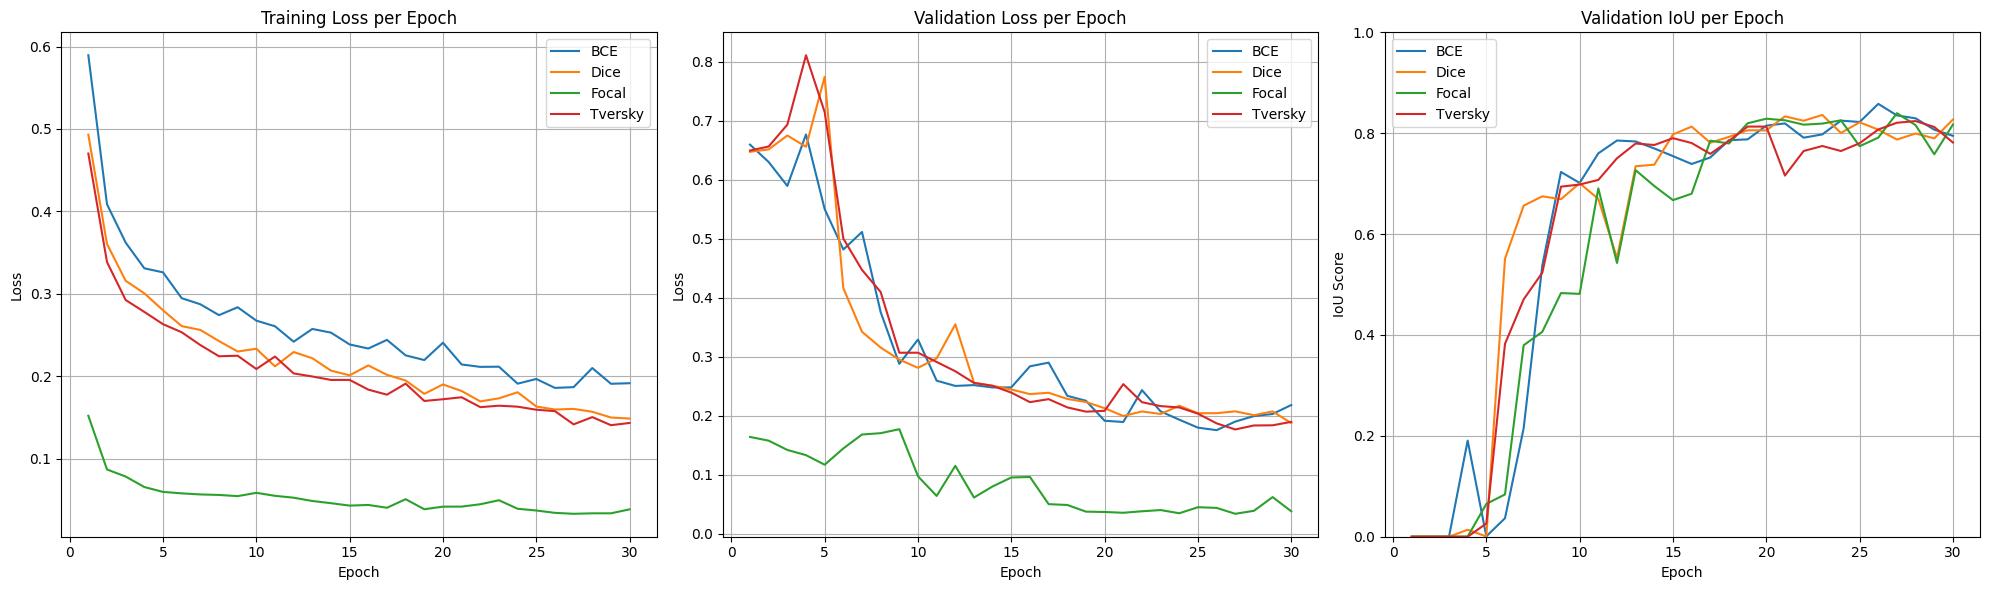

In [ ]:
stats_list_unet = {
    "BCE": statistics_bce_unet,
    "Dice": statistics_dice_unet,
    "Focal": statistics_focal_unet,
    "Tversky": statistics_tversky_unet,
}

train_loss_key = 'train loss'
val_loss_key = 'val_loss'
val_iou_key = 'val_iou'


num_epochs = 30
epochs = range(1, num_epochs + 1)


# --- Создание графиков ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- График 1: Training Loss ---
ax = axes[0]
for name, stats in stats_list_unet.items():
    ax.plot(epochs, stats[train_loss_key], label=f'{name}')

ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

# --- График 2: Validation Loss ---
ax = axes[1]
for name, stats in stats_list_unet.items():
    ax.plot(epochs, stats[val_loss_key], label=f'{name}')

ax.set_title('Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

# --- График 3: Validation IoU ---
ax = axes[2]
for name, stats in stats_list_unet.items():
    ax.plot(epochs, stats[val_iou_key], label=f'{name}')

ax.set_title('Validation IoU per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('IoU Score')

ax.set_ylim(0, 1)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


**SegNet VS UNet Сравнение графиков**


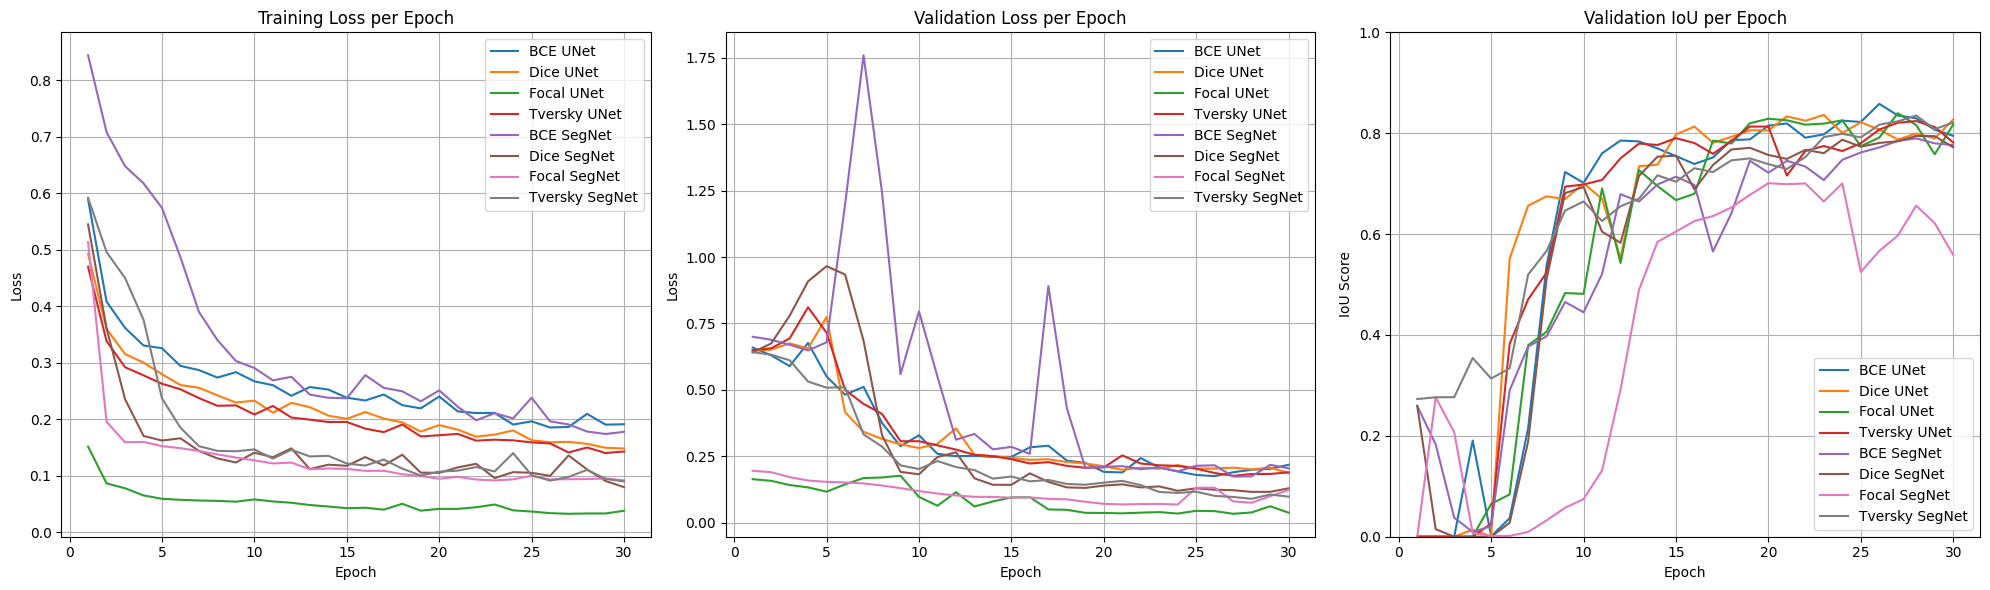

In [ ]:
stats_list_total = {
    "BCE UNet": statistics_bce_unet,
    "Dice UNet": statistics_dice_unet,
    "Focal UNet": statistics_focal_unet,
    "Tversky UNet": statistics_tversky_unet,
    "BCE SegNet": statistics_bce_segnet,
    "Dice SegNet": statistics_dice_segnet,
    "Focal SegNet": statistics_focal_segnet,
    "Tversky SegNet": statistics_tversky_segnet,
}

train_loss_key = 'train loss'
val_loss_key = 'val_loss'
val_iou_key = 'val_iou'


num_epochs = 30
epochs = range(1, num_epochs + 1)


# --- Создание графиков ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- График 1: Training Loss ---
ax = axes[0]
for name, stats in stats_list_total.items():
    ax.plot(epochs, stats[train_loss_key], label=f'{name}')

ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

# --- График 2: Validation Loss ---
ax = axes[1]
for name, stats in stats_list_total.items():
    ax.plot(epochs, stats[val_loss_key], label=f'{name}')

ax.set_title('Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True)

# --- График 3: Validation IoU ---
ax = axes[2]
for name, stats in stats_list_total.items():
    ax.plot(epochs, stats[val_iou_key], label=f'{name}')

ax.set_title('Validation IoU per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('IoU Score')

ax.set_ylim(0, 1)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

**СРАВНЕНИЕ UNet и SegNet**

Лучшей метрики достигла UNet с BCE (0.858)

Лучше всего сходилась модель SegNet с Tverky loss (я не считаю Focal loss опять же потому что он показал подозрительно низкие значения изначально)

Быстрее всего рубеж в 0.8 IoU score преодолела UNet Dice на 16 эпохе, но к этому также была близка и UNet BCE, показав на 12 эпохе IoU score 0.785

Визуально графики сходимости UNet выглядят стабильнее, чем SegNet, и эта модель в среднем достигает более высокие значения IoU